In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras import optimizers
from keras.applications import VGG16, VGG19
from keras.preprocessing.image import ImageDataGenerator

import os
import shutil
import cv2
from glob import glob
import random

from numpy.random import seed
seed(100)
from tensorflow import set_random_seed
set_random_seed(101)

from keras.utils import print_summary

import seaborn as sns
sns.set()

import datetime
import time
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

original_start = datetime.datetime.now()



Using TensorFlow backend.


In [2]:
train_dir = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/'
test_dir = '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/'
custom_test_dir = '../input/asl-alphabet-test/asl-alphabet-test/'

classes = [folder[len(train_dir):] for folder in glob(train_dir + '/*')] #creating labels based on subdirectories

classes #sanity check

['F',
 'V',
 'Q',
 'I',
 'N',
 'W',
 'D',
 'C',
 'A',
 'E',
 'X',
 'Y',
 'K',
 'O',
 'L',
 'P',
 'del',
 'R',
 'B',
 'G',
 'Z',
 'M',
 'H',
 'U',
 'nothing',
 'S',
 'T',
 'J',
 'space']

Markdown: Initial EDA 

In [3]:
import random

def plot_one_sample_of_each(base_path):
    cols = 5
    rows = int(np.ceil(len(classes)/cols))
    fig = plt.figure(figsize=(16,20))
    
    for i in range(len(classes)):
        cls = classes[i]
        img_path = base_path + '/' + cls + '/**'
        path_contents = glob(img_path)
        
        imgs = random.sample(path_contents, 1)
        
        sp = plt.subplot(rows, cols, i+1)
        plt.imshow(cv2.imread(imgs[0]))
        plt.title(cls)
        sp.axis('off')
        
    plt.show()
    return
    

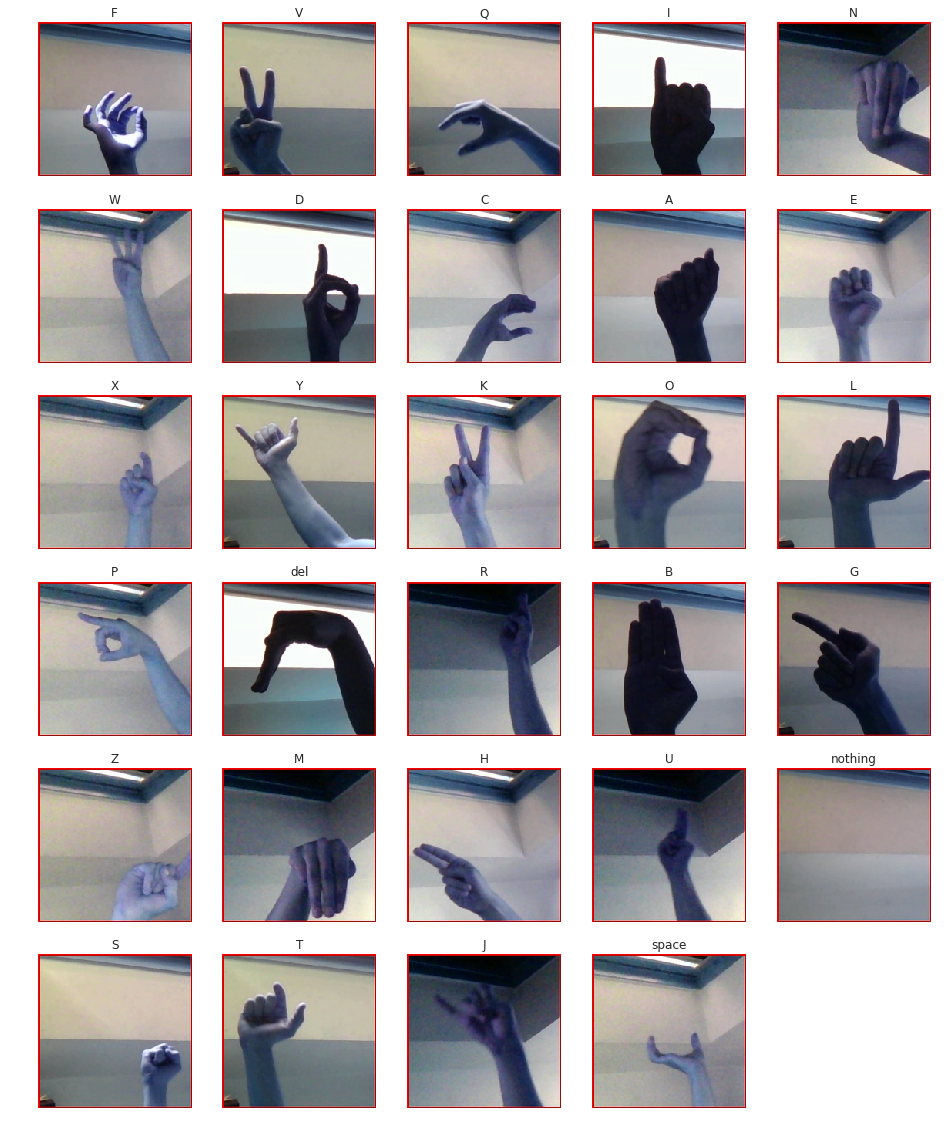

In [4]:
plot_one_sample_of_each(train_dir)

Markdown: Commentary on image plots of training set

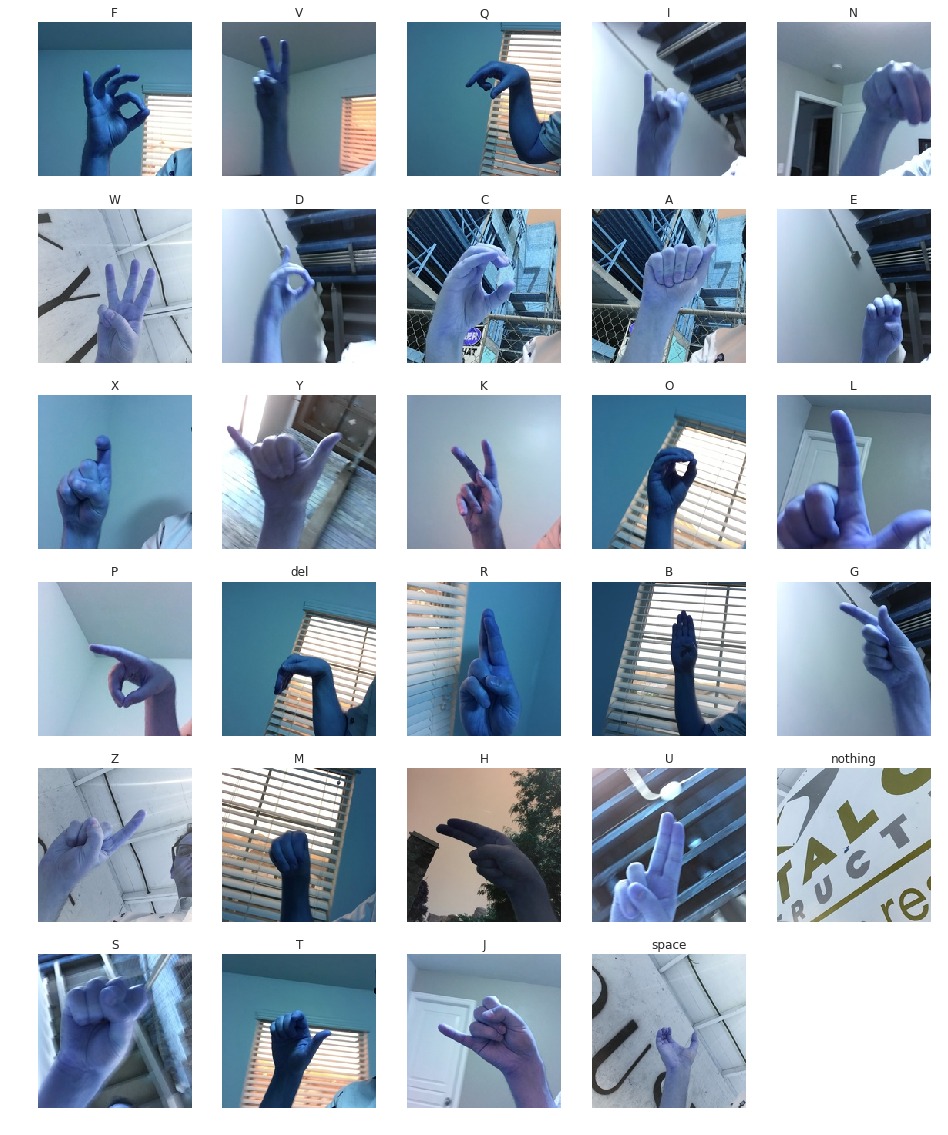

In [5]:
plot_one_sample_of_each(custom_test_dir)

In [6]:
def get_img_size(img_path):
    img = cv2.imread(img_path)
    height, width, channels = img.shape
    return height, width, channels

In [7]:
train_img_path_1 = train_dir + '/A/A1057.jpg'
train_img_size_1 = get_img_size(train_img_path_1)
train_img_size_1

test_img_path_1 = custom_test_dir + '/A/A0001_test.jpg'
test_img_size_1 = get_img_size(test_img_path_1)
test_img_size_1

train_img_size_1 == test_img_size_1

True

In [8]:
def plot_pixels(img):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(img)
    plt.axis('off')
    
    hist = plt.subplot(122)
    hist.set_xlabel('Count')
    hist.set_ylabel('Pixel Intensity')
    
    plt.hist(img[:,:,0].flatten(), bins=29, lw=0, color='r', alpha=0.5)
    plt.hist(img[:,:,1].flatten(), bins=29, lw=0, color='b', alpha=0.5)
    plt.hist(img[:,:,2].flatten(), bins=29, lw=0, color='g', alpha=0.5)
    
    return

In [11]:
from sklearn.model_selection import train_test_split
import keras

labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}

def load_data():
    images = []
    labels = []
    size = 64,64
    print("LOADING DATA FROM: ", end=" ")
    for folder in os.listdir(train_dir):
        print(folder, end = " | ")
        for image in os.listdir(train_dir + '/' + folder):
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            images.append(temp_img)
            if folder == 'A':
                labels.append(labels_dict['A'])
            elif folder == 'B':
                labels.append(labels_dict['B'])
            elif folder == 'C':
                labels.append(labels_dict['C'])
            elif folder == 'D':
                labels.append(labels_dict['D'])
            elif folder == 'E':
                labels.append(labels_dict['E'])
            elif folder == 'F':
                labels.append(labels_dict['F'])
            elif folder == 'G':
                labels.append(labels_dict['G'])
            elif folder == 'H':
                labels.append(labels_dict['H'])
            elif folder == 'I':
                labels.append(labels_dict['I'])
            elif folder == 'J':
                labels.append(labels_dict['J'])
            elif folder == 'K':
                labels.append(labels_dict['K'])
            elif folder == 'L':
                labels.append(labels_dict['L'])
            elif folder == 'M':
                labels.append(labels_dict['M'])
            elif folder == 'N':
                labels.append(labels_dict['N'])
            elif folder == 'O':
                labels.append(labels_dict['O'])
            elif folder == 'P':
                labels.append(labels_dict['P'])
            elif folder == 'Q':
                labels.append(labels_dict['Q'])
            elif folder == 'R':
                labels.append(labels_dict['R'])
            elif folder == 'S':
                labels.append(labels_dict['S'])
            elif folder == 'T':
                labels.append(labels_dict['T'])
            elif folder == 'U':
                labels.append(labels_dict['U'])
            elif folder == 'V':
                labels.append(labels_dict['V'])
            elif folder == 'W':
                labels.append(labels_dict['W'])
            elif folder == 'X':
                labels.append(labels_dict['X'])
            elif folder == 'Y':
                labels.append(labels_dict['Y'])
            elif folder == 'Z':
                labels.append(labels_dict['Z'])
            elif folder == 'space':
                labels.append(labels_dict['space'])
            elif folder == 'del':
                labels.append(labels_dict['del'])
            elif folder == 'nothing':
                labels.append(labels_dict['nothing'])
    
    images = np.array(images)
    images = images.astype('float32')/255.0
    
    templabels = labels
    labels = keras.utils.to_categorical(labels)
    
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1)
    
    print()
    print('Loaded', len(X_train), 'images for training', 'Train Data Shape', X_train.shape)
    print('Loaded', len(X_test), 'images for testing', 'Test Data Shape', X_test.shape)
    
    return X_train, X_test, y_train, y_test, templabels

LOADING DATA FROM:  F | V | Q | I | N | W | D | C | A | E | X | Y | K | O | L | P | del | R | B | G | Z | M | H | U | nothing | S | T | J | space | 
Loaded 78300 images for training Train Data Shape (78300, 64, 64, 3)
Loaded 8700 images for testing Test Data Shape (8700, 64, 64, 3)


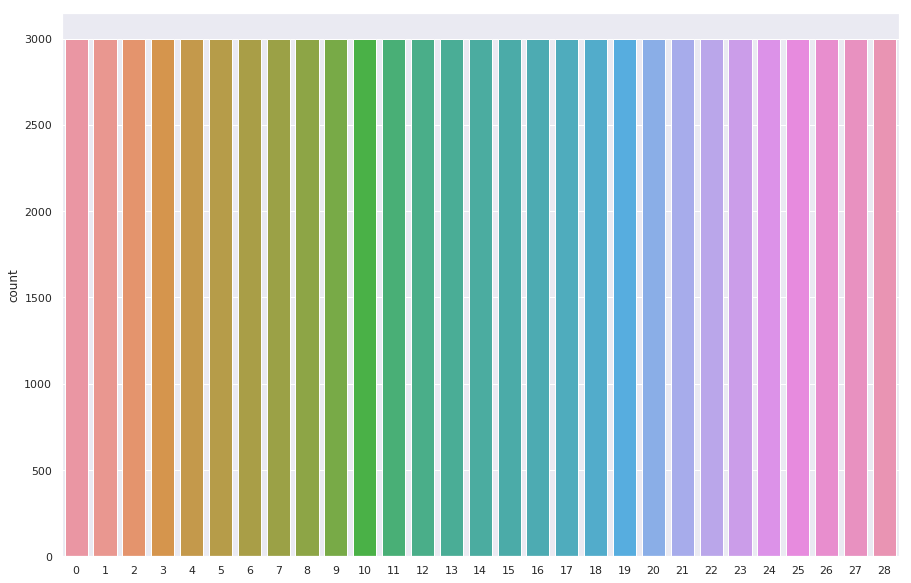

In [12]:
X_train, X_test, y_train, y_test, labels = load_data()

new_df = pd.DataFrame()
new_df["labels"] = labels
values = new_df["labels"].value_counts
sns.set(rc={'figure.figsize':(15,10)})
sns.countplot(labels)

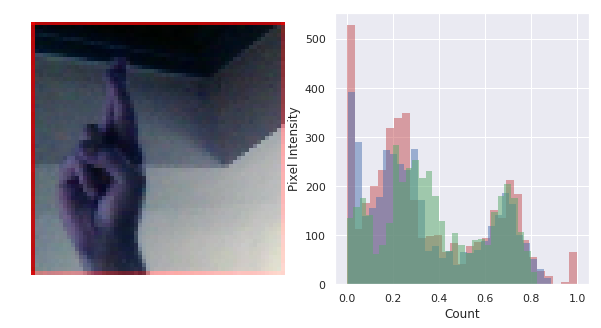

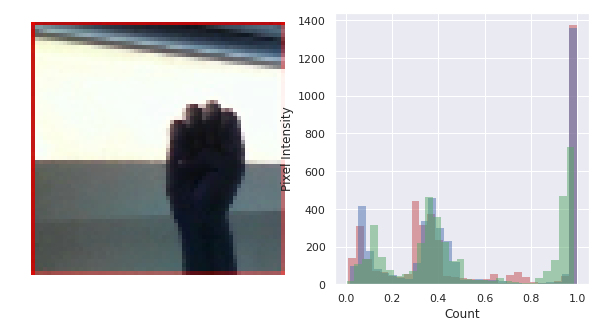

In [13]:
plot_pixels(X_train[0])
plot_pixels(X_train[200])

In [20]:
data_dir = train_dir
target_size = (64,64)
target_dims = (64,64,3)
n_classes = 29
val_frac = 0.1
batch_size = 64

data_augmentor = ImageDataGenerator(rescale=1./255,
                                    samplewise_center=True,
                                    samplewise_std_normalization=True,
                                    validation_split=val_frac)

train_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size,
                                                    batch_size=batch_size, shuffle=True, subset='training')

val_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size,
                                                  batch_size=batch_size, subset='validation')

steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)


test_generator = data_augmentor.flow_from_directory(custom_test_dir,
                                                 target_size= target_size,
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False)



Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.
Found 870 images belonging to 29 classes.


In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return



def plot_confusion_matrix_with_default_options(y_pred, y_true, classes):
   
    cm = confusion_matrix(y_true, y_pred)
    with sns.axes_style('ticks'):
        plt.figure(figsize=(16, 16))
        plot_confusion_matrix(cm, classes)
        plt.show()
    return

In [22]:
def test_model_acc(model):
    steps=(870/batch_size)
    test_loss, test_acc = model.evaluate_generator(test_generator, steps=steps)
    y_hat_test = model.predict_generator(test_generator, steps=steps)
    
    #predictions = model.predict_generator(test_generator)
    y_pred = np.argmax(y_hat_test, axis=1)
    y_true = test_generator.classes
    
    plot_confusion_matrix_with_default_options(y_pred, y_true, classes)
    
    print('Generated {} predictions'.format(len(y_hat_test)))
    print('Custom Test Accuracy:', test_acc)
    return dict(y_pred=y_pred, y_true=y_true)
    
def plot_acc_and_loss(model_history):

    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']

    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.subplots(figsize=(15,6))
    plt.subplot(121)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro--', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.subplot(122)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro--', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.show()
    
    return

In [23]:
dense_layers = [0, 1, 2]
layer_sizes = [32, 64, 128]
conv_layers = [1, 2, 3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            model_name = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(model_name)

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), activation='relu', input_shape=target_dims))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3), activation='relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())
            for _ in range(dense_layer):
                model.add(Dense(layer_size, activation='relu'))
               

            model.add(Dense(29, activation='softmax'))
           
            
            model.compile(loss='categorical_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )
            start = datetime.datetime.now()


            history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch,
                              validation_steps=validation_steps, epochs=5, validation_data=val_generator)
                      
            end = datetime.datetime.now()
            print("Total runtime for {} is {}".format(model_name, end-start))

1-conv-32-nodes-0-dense-1569158560
Epoch 1/5
1224/1224 [==============================] - 125s 102ms/step - loss: 0.7716 - acc: 0.7793 - val_loss: 1.3262 - val_acc: 0.6487
Epoch 2/5
1224/1224 [==============================] - 123s 100ms/step - loss: 0.1546 - acc: 0.9535 - val_loss: 1.3192 - val_acc: 0.6883
Epoch 3/5
1224/1224 [==============================] - 122s 100ms/step - loss: 0.0833 - acc: 0.9760 - val_loss: 1.4802 - val_acc: 0.7033
Epoch 4/5
1224/1224 [==============================] - 125s 102ms/step - loss: 0.0613 - acc: 0.9813 - val_loss: 1.8024 - val_acc: 0.6811
Epoch 5/5
1224/1224 [==============================] - 124s 101ms/step - loss: 0.0646 - acc: 0.9835 - val_loss: 1.7130 - val_acc: 0.7118
Total runtime for 1-conv-32-nodes-0-dense-1569158560 is 0:10:18.463322
2-conv-32-nodes-0-dense-1569159179
Epoch 1/5
1224/1224 [==============================] - 124s 101ms/step - loss: 0.5576 - acc: 0.8360 - val_loss: 1.3497 - val_acc: 0.7185
Epoch 2/5
1224/1224 [================

Epoch 3/5
1224/1224 [==============================] - 127s 104ms/step - loss: 0.1340 - acc: 0.9562 - val_loss: 0.8947 - val_acc: 0.7811
Epoch 4/5
1224/1224 [==============================] - 127s 104ms/step - loss: 0.0839 - acc: 0.9723 - val_loss: 1.0012 - val_acc: 0.7853
Epoch 5/5
1224/1224 [==============================] - 127s 104ms/step - loss: 0.0643 - acc: 0.9783 - val_loss: 0.9389 - val_acc: 0.7972
Total runtime for 2-conv-32-nodes-1-dense-1569164858 is 0:10:38.749488
3-conv-32-nodes-1-dense-1569165497
Epoch 1/5
1224/1224 [==============================] - 131s 107ms/step - loss: 1.0472 - acc: 0.6871 - val_loss: 1.2059 - val_acc: 0.7113
Epoch 2/5
1224/1224 [==============================] - 127s 104ms/step - loss: 0.1572 - acc: 0.9484 - val_loss: 1.2676 - val_acc: 0.7645
Epoch 3/5
1224/1224 [==============================] - 127s 104ms/step - loss: 0.0706 - acc: 0.9770 - val_loss: 1.2504 - val_acc: 0.7970
Epoch 4/5
1224/1224 [==============================] - 128s 104ms/step -

1224/1224 [==============================] - 131s 107ms/step - loss: 0.0580 - acc: 0.9801 - val_loss: 1.1845 - val_acc: 0.7840
Total runtime for 3-conv-32-nodes-2-dense-1569171367 is 0:10:55.893056
1-conv-64-nodes-2-dense-1569172023
Epoch 1/5
1224/1224 [==============================] - 133s 109ms/step - loss: 1.0649 - acc: 0.6608 - val_loss: 1.3787 - val_acc: 0.6287
Epoch 2/5
1224/1224 [==============================] - 131s 107ms/step - loss: 0.2482 - acc: 0.9152 - val_loss: 0.8648 - val_acc: 0.7463
Epoch 3/5
1224/1224 [==============================] - 130s 106ms/step - loss: 0.1387 - acc: 0.9516 - val_loss: 1.0032 - val_acc: 0.7709
Epoch 4/5
1224/1224 [==============================] - 130s 106ms/step - loss: 0.1067 - acc: 0.9639 - val_loss: 0.9511 - val_acc: 0.7980
Epoch 5/5
1224/1224 [==============================] - 130s 106ms/step - loss: 0.0875 - acc: 0.9706 - val_loss: 1.0141 - val_acc: 0.7884
Total runtime for 1-conv-64-nodes-2-dense-1569172023 is 0:10:54.083446
2-conv-64-n

In [24]:
def build_fit_test_cnn(optimizer, epochs):
    
    model = Sequential()
    
    model.add(Conv2D(64,(3,3), strides = 1, activation='relu', 
                            input_shape=target_dims))
    model.add(Conv2D(64, (3,3), strides = 2, activation='relu'))
    
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, (3,3), strides = 1, activation='relu'))
    model.add(Conv2D(128, (3,3), strides = 2, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(256, (3,3), strides= 1, activation='relu'))
    model.add(Conv2D(256, (3,3), strides= 2, activation='relu'))

    model.add(Dropout(0.5))
   
    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(29, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
    
    start = datetime.datetime.now()
    
    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, 
                              validation_data = val_generator, validation_steps=validation_steps)
    
    model_name = "{}-optimizer-{}-epochs-".format(optimizer, epochs)
    
    end = datetime.datetime.now()
    elapsed = end - start
    print('Total training time for model {}: {}'.format(model_name, elapsed))
                                
    test_model_acc(model)
    plot_acc_and_loss(history)
    
                                  
    return                          

Epoch 1/5
1224/1224 [==============================] - 137s 112ms/step - loss: 1.5982 - acc: 0.4888 - val_loss: 0.7143 - val_acc: 0.7485
Epoch 2/5
1224/1224 [==============================] - 134s 110ms/step - loss: 0.4874 - acc: 0.8299 - val_loss: 0.4762 - val_acc: 0.8408
Epoch 3/5
1224/1224 [==============================] - 133s 108ms/step - loss: 0.3036 - acc: 0.8973 - val_loss: 0.4103 - val_acc: 0.8641
Epoch 4/5
1224/1224 [==============================] - 134s 109ms/step - loss: 0.2368 - acc: 0.9203 - val_loss: 0.3874 - val_acc: 0.8744
Epoch 5/5
1224/1224 [==============================] - 132s 108ms/step - loss: 0.1931 - acc: 0.9347 - val_loss: 0.4260 - val_acc: 0.8661
Total training time for model adam-optimizer-5-epochs-: 0:11:11.586189


<Figure size 1152x1152 with 0 Axes>

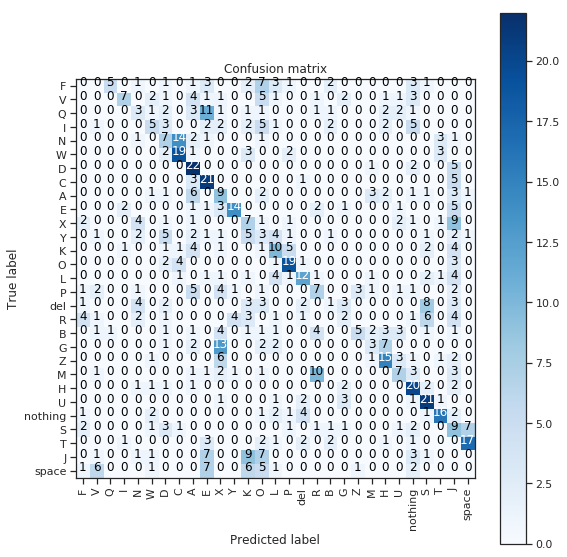

Generated 870 predictions
Custom Test Accuracy: 0.3747126424449614


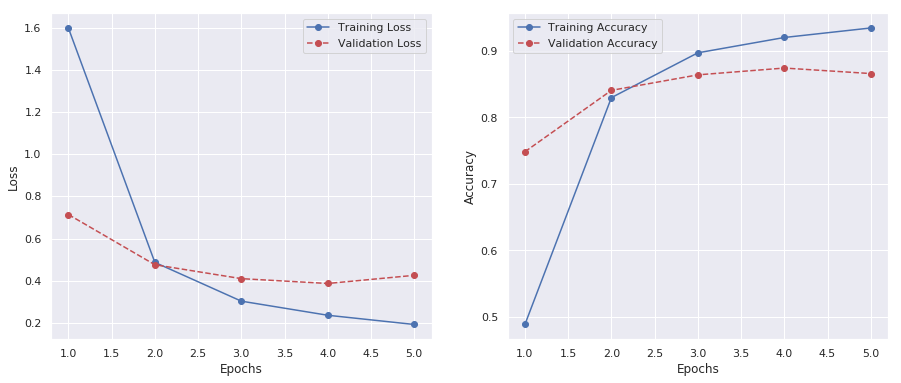

Epoch 1/10
1224/1224 [==============================] - 137s 112ms/step - loss: 1.5810 - acc: 0.4932 - val_loss: 0.6978 - val_acc: 0.7420
Epoch 2/10
1224/1224 [==============================] - 133s 109ms/step - loss: 0.4814 - acc: 0.8321 - val_loss: 0.4779 - val_acc: 0.8306
Epoch 3/10
1224/1224 [==============================] - 134s 110ms/step - loss: 0.2945 - acc: 0.8986 - val_loss: 0.4132 - val_acc: 0.8639
Epoch 4/10
1224/1224 [==============================] - 134s 109ms/step - loss: 0.2296 - acc: 0.9232 - val_loss: 0.3420 - val_acc: 0.8867
Epoch 5/10
1224/1224 [==============================] - 133s 109ms/step - loss: 0.1951 - acc: 0.9369 - val_loss: 0.4116 - val_acc: 0.8772
Epoch 6/10
1224/1224 [==============================] - 134s 109ms/step - loss: 0.1703 - acc: 0.9445 - val_loss: 0.4305 - val_acc: 0.8753
Epoch 7/10
1224/1224 [==============================] - 132s 108ms/step - loss: 0.1553 - acc: 0.9506 - val_loss: 0.3943 - val_acc: 0.8849
Epoch 8/10
1224/1224 [============

<Figure size 1152x1152 with 0 Axes>

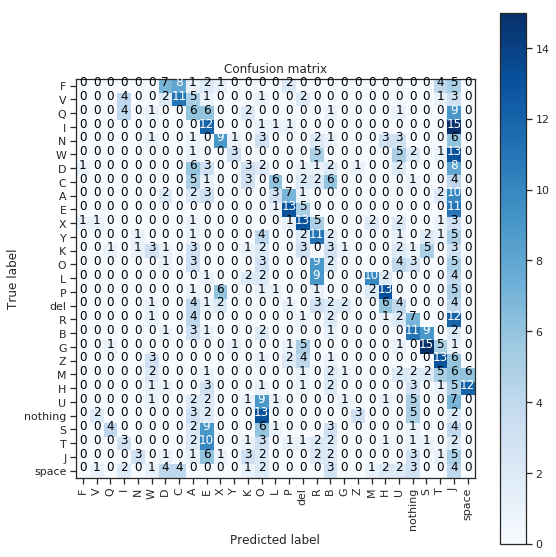

Generated 870 predictions
Custom Test Accuracy: 0.311494252736541


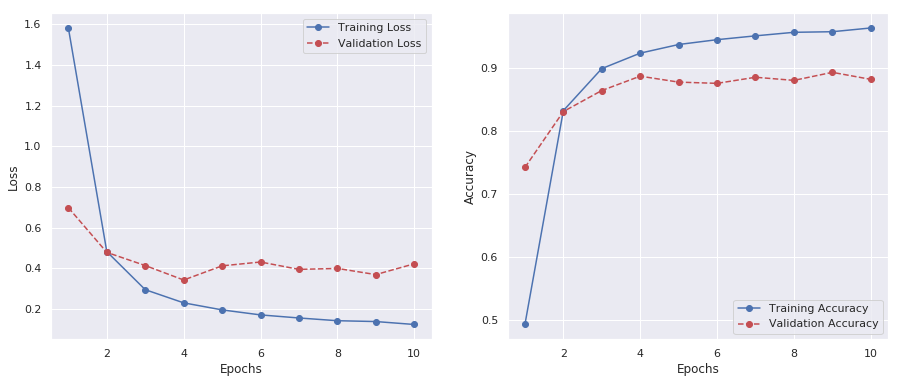

Epoch 1/5
1224/1224 [==============================] - 137s 112ms/step - loss: 2.1225 - acc: 0.3644 - val_loss: 0.8615 - val_acc: 0.6818
Epoch 2/5
1224/1224 [==============================] - 133s 109ms/step - loss: 0.6850 - acc: 0.7561 - val_loss: 0.5297 - val_acc: 0.8052
Epoch 3/5
1224/1224 [==============================] - 134s 109ms/step - loss: 0.4340 - acc: 0.8464 - val_loss: 0.5146 - val_acc: 0.8305
Epoch 4/5
1224/1224 [==============================] - 133s 109ms/step - loss: 0.3222 - acc: 0.8871 - val_loss: 0.4330 - val_acc: 0.8545
Epoch 5/5
1224/1224 [==============================] - 134s 109ms/step - loss: 0.2560 - acc: 0.9099 - val_loss: 0.3868 - val_acc: 0.8714
Total training time for model Adagrad-optimizer-5-epochs-: 0:11:11.114488


<Figure size 1152x1152 with 0 Axes>

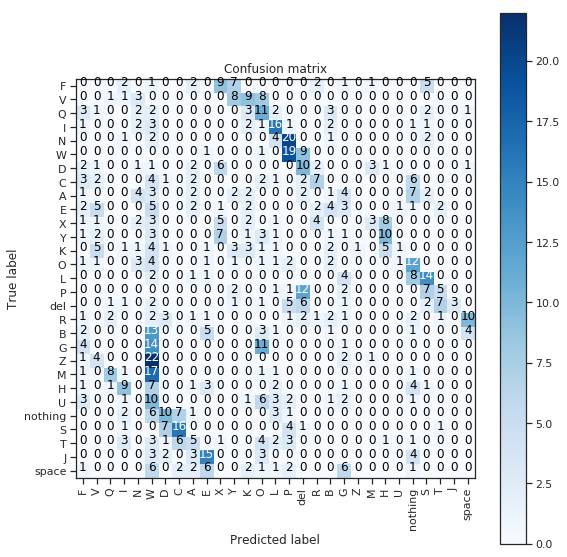

Generated 870 predictions
Custom Test Accuracy: 0.3609195400243518


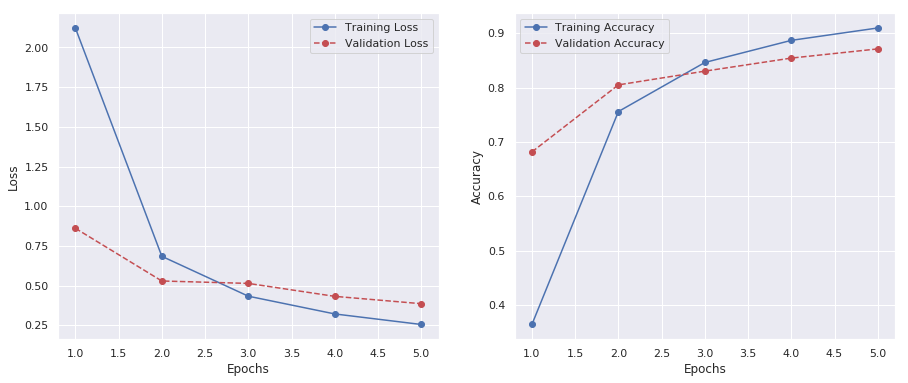

Epoch 1/10
1224/1224 [==============================] - 138s 113ms/step - loss: 1.8855 - acc: 0.4110 - val_loss: 0.9732 - val_acc: 0.6436
Epoch 2/10
1224/1224 [==============================] - 134s 110ms/step - loss: 0.6004 - acc: 0.7861 - val_loss: 0.7105 - val_acc: 0.7737
Epoch 3/10
1224/1224 [==============================] - 134s 109ms/step - loss: 0.3631 - acc: 0.8702 - val_loss: 0.5376 - val_acc: 0.8340
Epoch 4/10
1224/1224 [==============================] - 135s 110ms/step - loss: 0.2686 - acc: 0.9039 - val_loss: 0.5998 - val_acc: 0.8207
Epoch 5/10
1224/1224 [==============================] - 135s 111ms/step - loss: 0.2058 - acc: 0.9268 - val_loss: 0.5857 - val_acc: 0.8426
Epoch 6/10
1224/1224 [==============================] - 135s 111ms/step - loss: 0.1681 - acc: 0.9405 - val_loss: 0.6180 - val_acc: 0.8467
Epoch 7/10
1224/1224 [==============================] - 136s 111ms/step - loss: 0.1489 - acc: 0.9478 - val_loss: 0.5988 - val_acc: 0.8559
Epoch 8/10
1224/1224 [============

<Figure size 1152x1152 with 0 Axes>

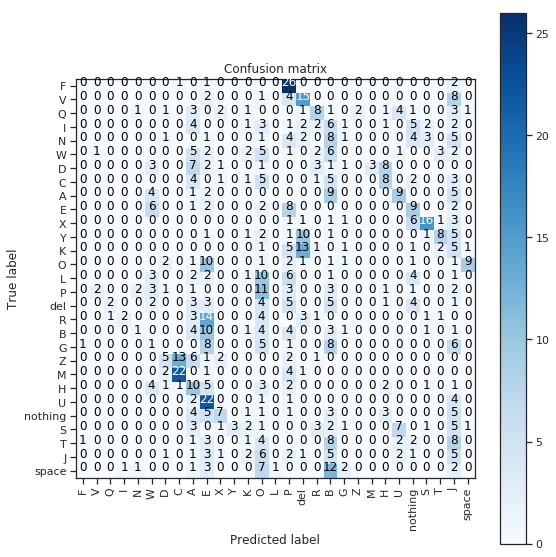

Generated 870 predictions
Custom Test Accuracy: 0.2551724140671478


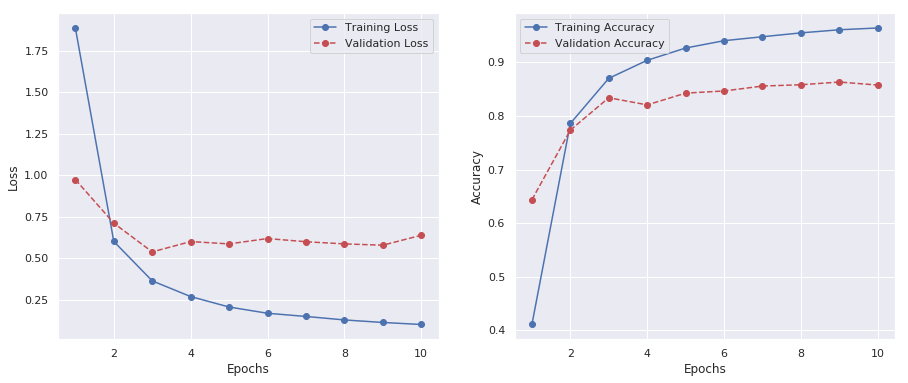

Epoch 1/5
1224/1224 [==============================] - 141s 115ms/step - loss: 1.7827 - acc: 0.4467 - val_loss: 1.0777 - val_acc: 0.6166
Epoch 2/5
1224/1224 [==============================] - 134s 110ms/step - loss: 0.4379 - acc: 0.8468 - val_loss: 0.4277 - val_acc: 0.8607
Epoch 3/5
1224/1224 [==============================] - 134s 109ms/step - loss: 0.2292 - acc: 0.9211 - val_loss: 0.2969 - val_acc: 0.8991
Epoch 4/5
1224/1224 [==============================] - 134s 109ms/step - loss: 0.1530 - acc: 0.9484 - val_loss: 0.3450 - val_acc: 0.8955
Epoch 5/5
1224/1224 [==============================] - 132s 108ms/step - loss: 0.1168 - acc: 0.9616 - val_loss: 0.3275 - val_acc: 0.9117
Total training time for model Adadelta-optimizer-5-epochs-: 0:11:16.157481


<Figure size 1152x1152 with 0 Axes>

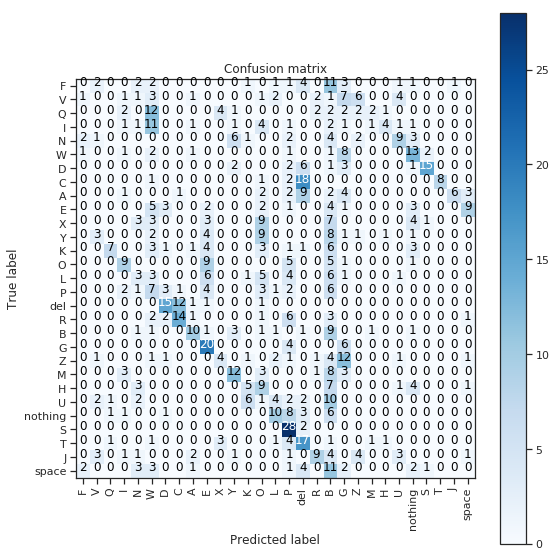

Generated 870 predictions
Custom Test Accuracy: 0.33908045956458166


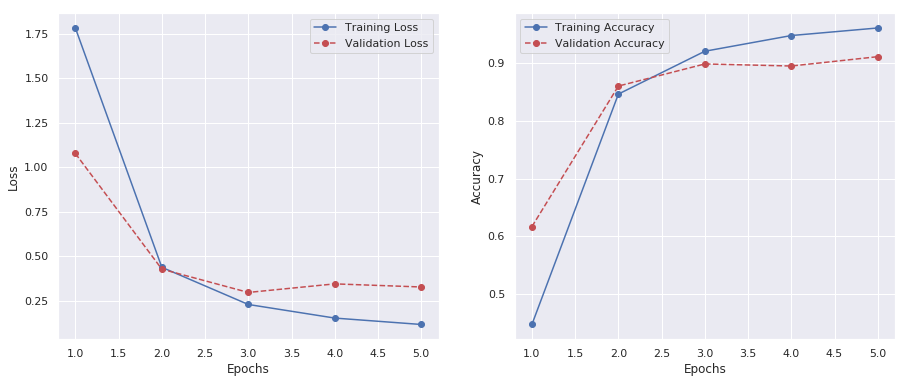

Epoch 1/10
1224/1224 [==============================] - 138s 113ms/step - loss: 1.8136 - acc: 0.4362 - val_loss: 0.7132 - val_acc: 0.7339
Epoch 2/10
1224/1224 [==============================] - 131s 107ms/step - loss: 0.4587 - acc: 0.8393 - val_loss: 0.4622 - val_acc: 0.8467
Epoch 3/10
1224/1224 [==============================] - 132s 108ms/step - loss: 0.2380 - acc: 0.9189 - val_loss: 0.4722 - val_acc: 0.8589
Epoch 4/10
1224/1224 [==============================] - 132s 108ms/step - loss: 0.1545 - acc: 0.9495 - val_loss: 0.3351 - val_acc: 0.9061
Epoch 5/10
1224/1224 [==============================] - 132s 108ms/step - loss: 0.1136 - acc: 0.9633 - val_loss: 0.3891 - val_acc: 0.9054
Epoch 6/10
1224/1224 [==============================] - 131s 107ms/step - loss: 0.0895 - acc: 0.9718 - val_loss: 0.3457 - val_acc: 0.9140
Epoch 7/10
1224/1224 [==============================] - 131s 107ms/step - loss: 0.0746 - acc: 0.9761 - val_loss: 0.3448 - val_acc: 0.9200
Epoch 8/10
1224/1224 [============

<Figure size 1152x1152 with 0 Axes>

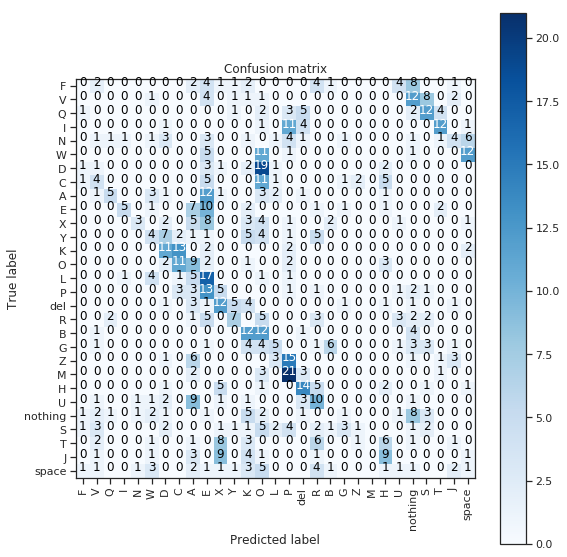

Generated 870 predictions
Custom Test Accuracy: 0.3517241387531675


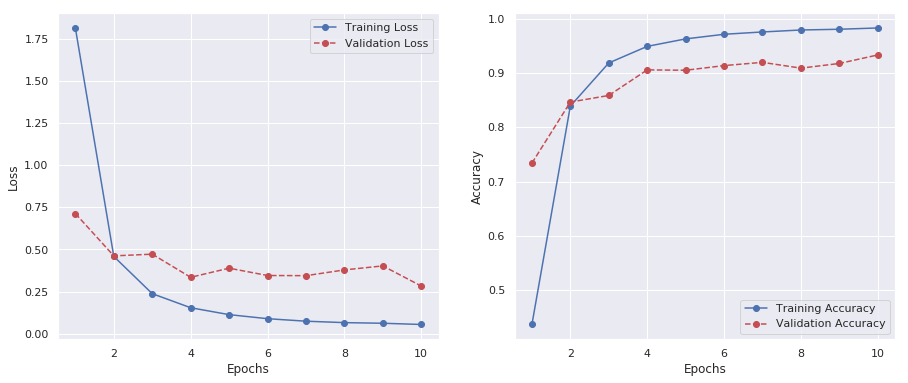

Epoch 1/5
1224/1224 [==============================] - 137s 112ms/step - loss: 1.8189 - acc: 0.4240 - val_loss: 0.9396 - val_acc: 0.6664
Epoch 2/5
1224/1224 [==============================] - 133s 108ms/step - loss: 0.5548 - acc: 0.8022 - val_loss: 0.4939 - val_acc: 0.8301
Epoch 3/5
1224/1224 [==============================] - 133s 108ms/step - loss: 0.3047 - acc: 0.8920 - val_loss: 0.4854 - val_acc: 0.8478
Epoch 4/5
1224/1224 [==============================] - 134s 109ms/step - loss: 0.1941 - acc: 0.9317 - val_loss: 0.3379 - val_acc: 0.8907
Epoch 5/5
1224/1224 [==============================] - 132s 108ms/step - loss: 0.1486 - acc: 0.9480 - val_loss: 0.4458 - val_acc: 0.8845
Total training time for model Adamax-optimizer-5-epochs-: 0:11:09.041518


<Figure size 1152x1152 with 0 Axes>

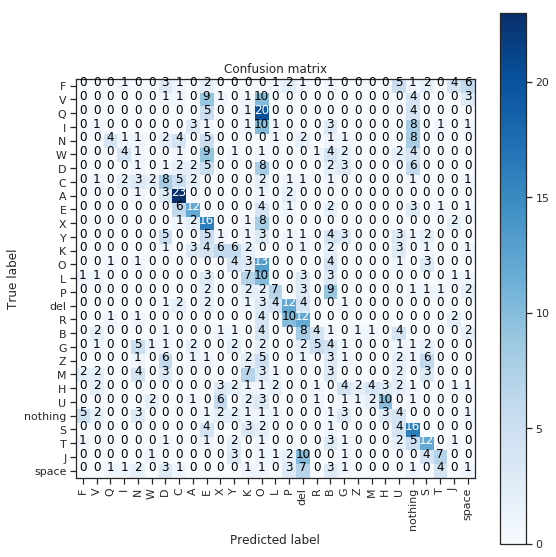

Generated 870 predictions
Custom Test Accuracy: 0.30459770142346965


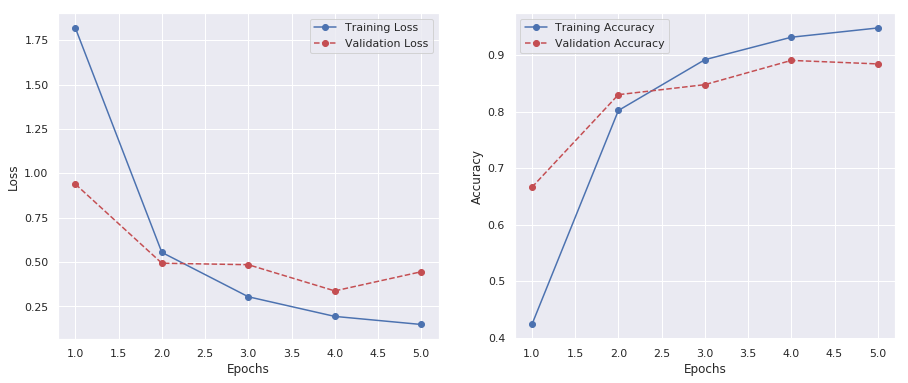

Epoch 1/10
1224/1224 [==============================] - 138s 112ms/step - loss: 1.8467 - acc: 0.4160 - val_loss: 0.9373 - val_acc: 0.6715
Epoch 2/10
1224/1224 [==============================] - 134s 110ms/step - loss: 0.5483 - acc: 0.8076 - val_loss: 0.4582 - val_acc: 0.8314
Epoch 3/10
1224/1224 [==============================] - 133s 108ms/step - loss: 0.2993 - acc: 0.8949 - val_loss: 0.3719 - val_acc: 0.8600
Epoch 4/10
1224/1224 [==============================] - 135s 110ms/step - loss: 0.1981 - acc: 0.9312 - val_loss: 0.3851 - val_acc: 0.8814
Epoch 5/10
1224/1224 [==============================] - 133s 109ms/step - loss: 0.1435 - acc: 0.9503 - val_loss: 0.3735 - val_acc: 0.8969
Epoch 6/10
1224/1224 [==============================] - 134s 110ms/step - loss: 0.1149 - acc: 0.9612 - val_loss: 0.3794 - val_acc: 0.8986
Epoch 7/10
1224/1224 [==============================] - 134s 109ms/step - loss: 0.0904 - acc: 0.9697 - val_loss: 0.3958 - val_acc: 0.8860
Epoch 8/10
1224/1224 [============

<Figure size 1152x1152 with 0 Axes>

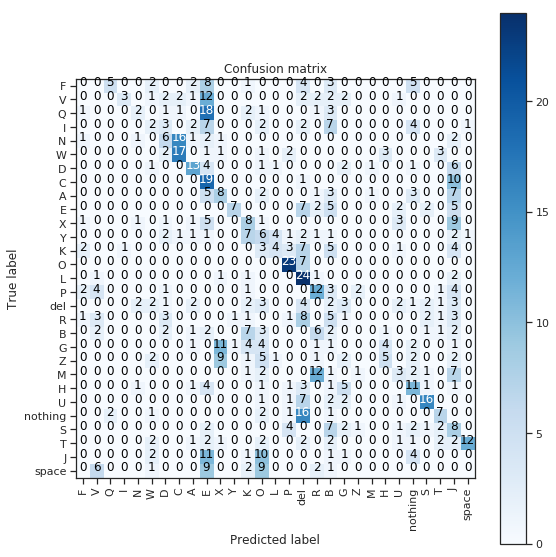

Generated 870 predictions
Custom Test Accuracy: 0.294252874042796


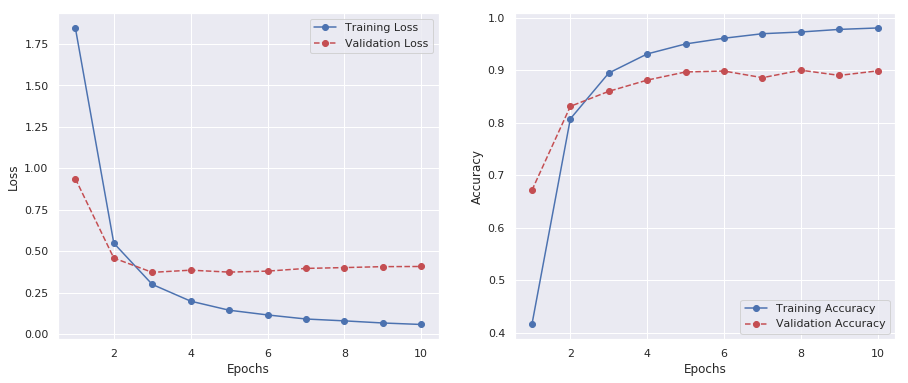

In [25]:
optimizers = ['adam', 'Adagrad', 'Adadelta', 'Adamax']
epochs = [5,10]
for o in optimizers:
    for e in epochs:
        build_fit_test_cnn(o,e)
        
        